In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.custom_layers import *
from lib.ibp_layers import *

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
def get_input_bound(x, eps):
    x_ub = torch.clamp(x + eps, 0, 1)
    x_lb = torch.clamp(x - eps, 0, 1)
    return x, x_ub, x_lb

In [5]:
exp = 8
model_name = 'mnist_linf_ibp_exp%d.h5' % exp

# net = IBPMedium()

# params = {'p': 2,
#           'epsilon': 1.5,
#           'input_bound': (0, 1)}
# net = IBPSmallCustom(LpLinear, params)
params = {'epsilon': 5,
          'input_bound': (0, 1)}
net = IBPSmallCustom(CardRelaxLinear, params)

In [6]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
net.eval()

IBPSmallCustom(
  (fc1): CardRelaxLinear(in_features=784, out_features=2000, bias=True)
  (relu1): IBPReLU()
  (fc2): IBPLinear()
  (relu2): IBPReLU()
  (fc3): IBPLinear()
  (relu3): IBPReLU()
  (fc4): IBPLinear()
)

In [7]:
(x_train, y_train), _, (x_test, y_test) = load_mnist_all(
    '/data', val_size=0, seed=seed)

In [8]:
eps = 1
params = {'p': 2,
          'epsilon': eps,
          'input_bound': (0, 1)}

with torch.no_grad():
    out = net.get_activations(x_test.cuda(), params)
    diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

In [9]:
(diff >= 0).float().mean()

tensor(0.9374, device='cuda:0')

In [24]:
(out[-1][0].argmax(1).cpu() == y_test).float().mean()

tensor(0.9586)

In [57]:
import matplotlib
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams["text.usetex"] = False

In [11]:
num = 50000
idx = 0

# l2
v = torch.normal(0., 1., size=(num, 784))
v = F.normalize(v, p=2, dim=1)
r = torch.rand((num, 784)) ** (1 / 784)
x = (eps * r * v).view(num, 1, 28, 28) + x_test[idx]
x = torch.clamp(x, 0, 1)

with torch.no_grad():
    z = net.get_activations(x.cuda(), params)

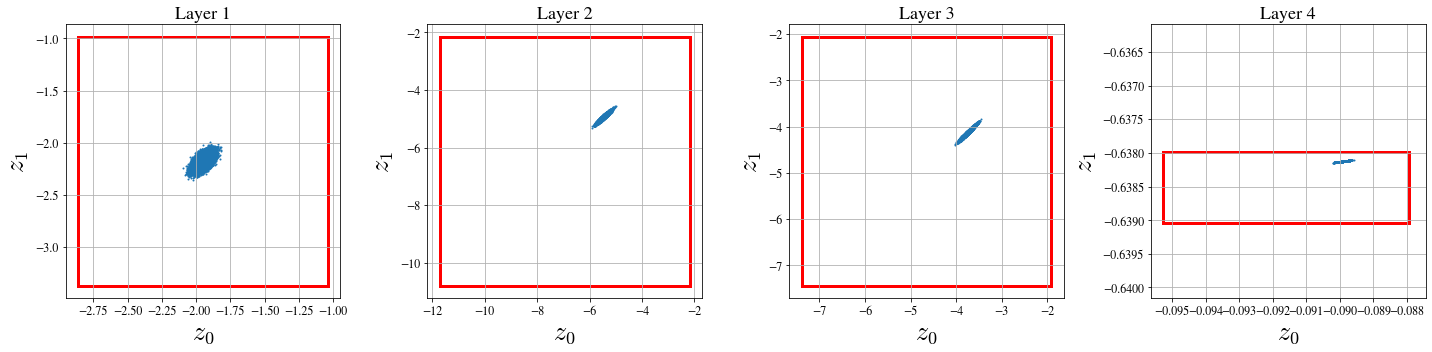

In [13]:
axis1 = 0
axis2 = 1

fig = plt.figure(figsize=(20, 5))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    z_ub = out[i][1].cpu().numpy()
    z_lb = out[i][2].cpu().numpy()
    z_0 = z[i][0].cpu().numpy()
    rc = Rectangle((z_lb[idx, axis1], z_lb[idx, axis2]), 
                   z_ub[idx, axis1] - z_lb[idx, axis1],
                   z_ub[idx, axis2] - z_lb[idx, axis2],
                   fill=False, color='r', lw=3)
    ax.add_patch(rc)
    plt.scatter(z_0[:, axis1], z_0[:, axis2], s=1)
    plt.grid(True)
    plt.xlabel(r'$z_0$', fontsize=26)
    plt.ylabel(r'$z_1$', fontsize=26)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Layer %d' % (i + 1), fontsize=18)
    plt.tight_layout()
plt.savefig('ibp_l2_15_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
eps = 0.1
params = {'epsilon': eps,
          'input_bound': (0, 1)}
net = IBPSmallCustom(IntLinear, params)

model_name = 'mnist_linf_ibp_exp23.h5'
model_path = os.path.join(save_dir, model_name)
net = net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

with torch.no_grad():
    out = net.get_activations(x_test.cuda(), params)
    diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

In [38]:
(diff >= 0).float().mean()

tensor(0.8135, device='cuda:0')

In [39]:
(out[-1][0].argmax(1).cpu() == y_test).float().mean()

tensor(0.9304)

In [40]:
num = 50000
idx = 0

# l-inf
noise = torch.rand((num, 784)) * 2 - 1
x = (eps * noise).view(num, 1, 28, 28) + x_test[idx]
x = torch.clamp(x, 0, 1)

with torch.no_grad():
    z = net.get_activations(x.cuda(), params)

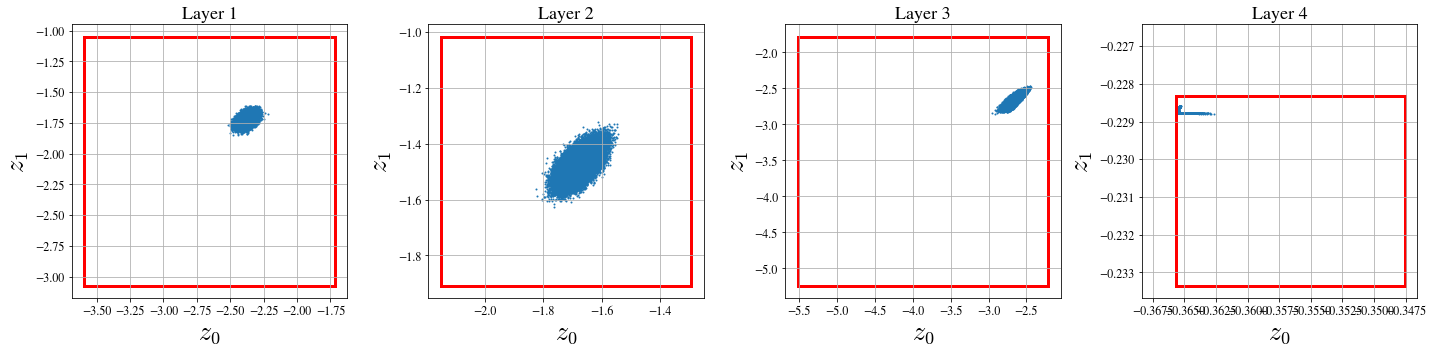

In [41]:
axis1 = 0
axis2 = 1

fig = plt.figure(figsize=(20, 5))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    z_ub = out[i][1].cpu().numpy()
    z_lb = out[i][2].cpu().numpy()
    z_0 = z[i][0].cpu().numpy()
    rc = Rectangle((z_lb[idx, axis1], z_lb[idx, axis2]), 
                   z_ub[idx, axis1] - z_lb[idx, axis1],
                   z_ub[idx, axis2] - z_lb[idx, axis2],
                   fill=False, color='r', lw=3)
    ax.add_patch(rc)
    plt.scatter(z_0[:, axis1], z_0[:, axis2], s=1)
    plt.grid(True)
    plt.xlabel(r'$z_0$', fontsize=26)
    plt.ylabel(r'$z_1$', fontsize=26)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Layer %d' % (i + 1), fontsize=18)
    plt.tight_layout()
plt.savefig('ibp_linf_02_01.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
epss = np.arange(0, 30, 1)
accs = []

for exp in [14, 15, 17]:
    model_name = 'mnist_linf_ibp_exp%d.h5' % exp
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = np.zeros(len(epss))

    for i, eps in enumerate(epss):
        params = {'epsilon': eps,
                  'input_bound': (0, 1)}

        with torch.no_grad():
            diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

        acc[i] = (diff >= 0).float().mean().item()
    accs.append(acc)

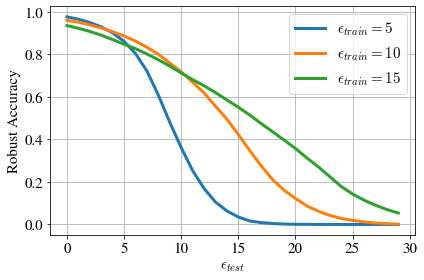

In [59]:
fs = 15
plt.plot(epss, accs[0], lw=3, label=r'$\epsilon_{train}=5$')
plt.plot(epss, accs[1], lw=3, label=r'$\epsilon_{train}=10$')
plt.plot(epss, accs[2], lw=3, label=r'$\epsilon_{train}=15$')
plt.xlabel(r'$\epsilon_{test}$', fontsize=fs)
plt.ylabel('Robust Accuracy', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.grid(True)
plt.tight_layout()
plt.savefig('ibp_l0_eps.png', dpi=300, bbox_inches='tight')
plt.show()

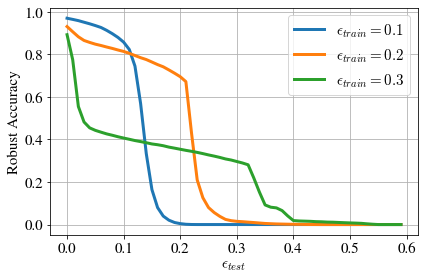

In [48]:
fs = 15
plt.plot(epss, accs[0], lw=3, label=r'$\epsilon_{train}=0.1$')
plt.plot(epss, accs[1], lw=3, label=r'$\epsilon_{train}=0.2$')
plt.plot(epss, accs[2], lw=3, label=r'$\epsilon_{train}=0.3$')
plt.xlabel(r'$\epsilon_{test}$', fontsize=fs)
plt.ylabel('Robust Accuracy', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.grid(True)
plt.tight_layout()
plt.savefig('ibp_linf_eps.png', dpi=300, bbox_inches='tight')
plt.show()

In [107]:
params = {'input_bound': (0, 1)}
net = IBPSmallCustom(PermS2Linear, params)

model_name = 'mnist_linf_ibp_exp25.h5'
model_path = os.path.join(save_dir, model_name)
net = net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

with torch.no_grad():
    out = net.get_activations(x_test.cuda(), params)
    diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

In [108]:
num = 50000
idx = 0

# swap2
x = torch.zeros(num, 784)
x += x_test[idx].view(-1)
rnd_idx = np.floor(np.random.uniform(size=(num, 2)) * 784).astype(int)
for i in range(num):
    temp = x[i, rnd_idx[i, 0]].clone()
    x[i, rnd_idx[i, 0]] = x[i, rnd_idx[i, 1]]
    x[i, rnd_idx[i, 1]] = temp

with torch.no_grad():
    z = net.get_activations(x.cuda(), params)

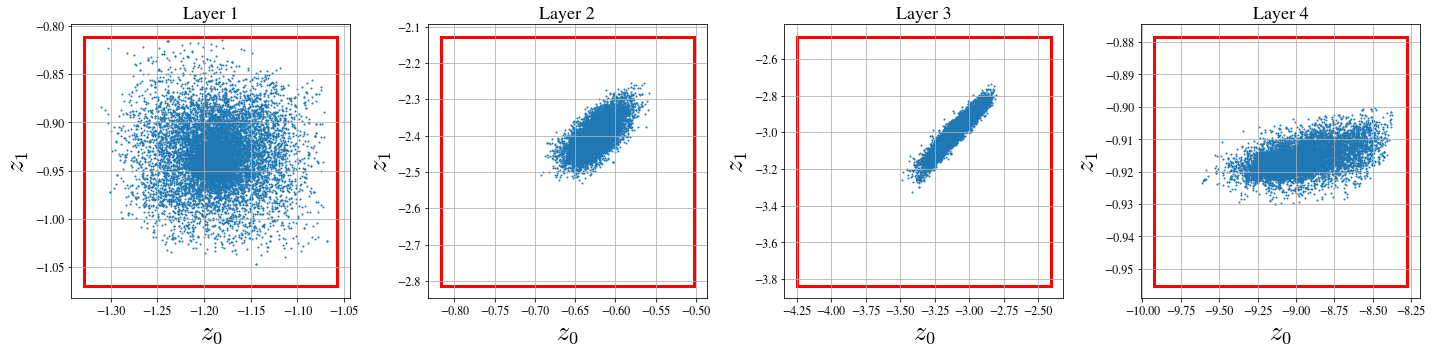

In [109]:
axis1 = 0
axis2 = 1

fig = plt.figure(figsize=(20, 5))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    z_ub = out[i][1].cpu().numpy()
    z_lb = out[i][2].cpu().numpy()
    z_0 = z[i][0].cpu().numpy()
    rc = Rectangle((z_lb[idx, axis1], z_lb[idx, axis2]), 
                   z_ub[idx, axis1] - z_lb[idx, axis1],
                   z_ub[idx, axis2] - z_lb[idx, axis2],
                   fill=False, color='r', lw=3)
    ax.add_patch(rc)
    plt.scatter(z_0[:, axis1], z_0[:, axis2], s=1)
    plt.grid(True)
    plt.xlabel(r'$z_0$', fontsize=26)
    plt.ylabel(r'$z_1$', fontsize=26)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Layer %d' % (i + 1), fontsize=18)
    plt.tight_layout()
plt.savefig('ibp_perm2.png', dpi=300, bbox_inches='tight')
plt.show()

In [126]:
eps = 10
params = {'epsilon': eps,
          'input_bound': (0, 1)}
net = IBPSmallCustom(CardRelaxLinear, params)

model_name = 'mnist_linf_ibp_exp15.h5'
model_path = os.path.join(save_dir, model_name)
net = net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

with torch.no_grad():
    out = net.get_activations(x_test.cuda(), params)
    diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

In [127]:
num = 50000
idx = 0

# l0
x = torch.zeros(num, 784)
x += x_test[idx].view(-1)
rnd_idx = np.floor(np.random.uniform(size=(num, 10)) * 784).astype(int)
for i in range(num):
    x[i, rnd_idx[i]] += torch.rand(eps) * 2 - 1
x = torch.clamp(x, 0, 1)

with torch.no_grad():
    z = net.get_activations(x.cuda(), params)

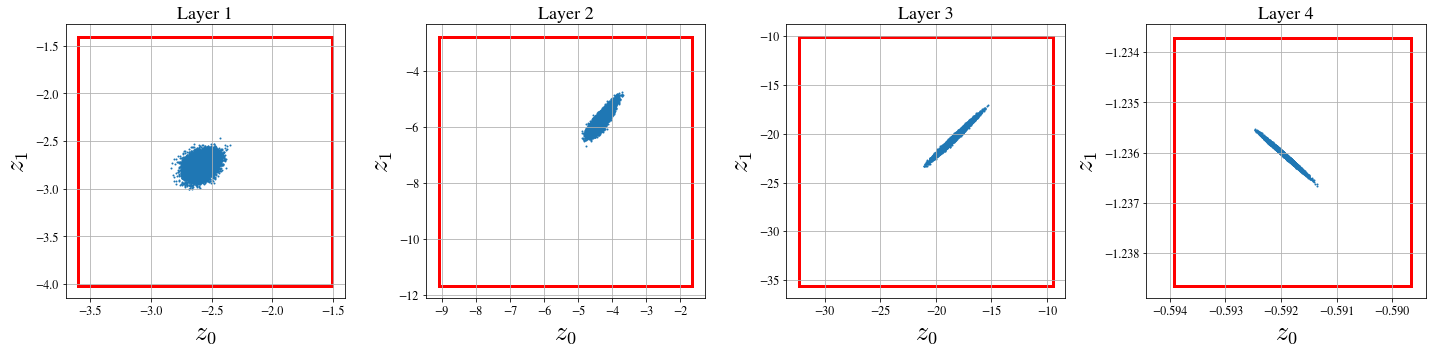

In [128]:
axis1 = 0
axis2 = 1

fig = plt.figure(figsize=(20, 5))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    z_ub = out[i][1].cpu().numpy()
    z_lb = out[i][2].cpu().numpy()
    z_0 = z[i][0].cpu().numpy()
    rc = Rectangle((z_lb[idx, axis1], z_lb[idx, axis2]), 
                   z_ub[idx, axis1] - z_lb[idx, axis1],
                   z_ub[idx, axis2] - z_lb[idx, axis2],
                   fill=False, color='r', lw=3)
    ax.add_patch(rc)
    plt.scatter(z_0[:, axis1], z_0[:, axis2], s=1)
    plt.grid(True)
    plt.xlabel(r'$z_0$', fontsize=26)
    plt.ylabel(r'$z_1$', fontsize=26)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Layer %d' % (i + 1), fontsize=18)
    plt.tight_layout()
plt.savefig('ibp_l0.png', dpi=300, bbox_inches='tight')
plt.show()

In [62]:
eps = 0.1

torch.manual_seed(2019)
Q = torch.randn(784, 784)
Q = Q @ Q.transpose(0, 1)
eig = torch.symeig(Q)[0]
Q /= eig.max()
Q += torch.eye(784) * eig.min().abs() * 2

params = {'Q_inv': Q.to(device).inverse(),
          'epsilon': eps,
          'input_bound': (0, 1)}
net = IBPSmallCustom(EllipsLinear, params)

model_name = 'mnist_linf_ibp_exp18.h5'
model_path = os.path.join(save_dir, model_name)
net = net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

with torch.no_grad():
    out = net.get_activations(x_test.cuda(), params)
    diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

In [63]:
(diff >= 0).float().mean()

tensor(0.8230, device='cuda:0')

In [64]:
num = 50000
idx = 0

# Ellip
v = torch.normal(0., 1., size=(num, 784))
v = F.normalize(v, p=2, dim=1)
r = torch.rand((num, 784)) ** (1 / 784)
x = eps * r * v
x = Q.inverse() @ x.transpose(0, 1) + x_test[idx].view(-1, 1)
# x = torch.clamp(x, 0, 1).transpose(0, 1)
x = x.transpose(0, 1)
# x = torch.clamp(x, 0, 1)

with torch.no_grad():
    z = net.get_activations(x.cuda(), params)

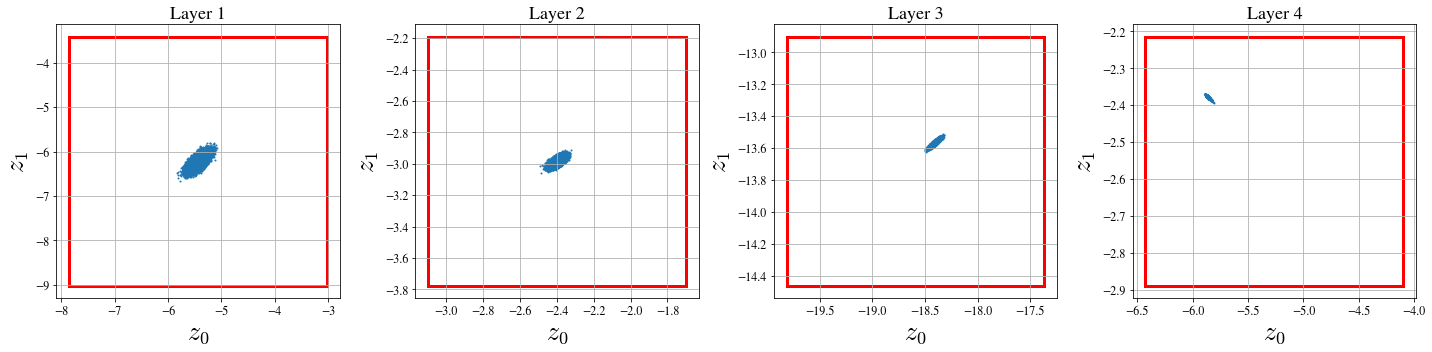

In [65]:
axis1 = 0
axis2 = 1

fig = plt.figure(figsize=(20, 5))

for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1)
    z_ub = out[i][1].cpu().numpy()
    z_lb = out[i][2].cpu().numpy()
    z_0 = z[i][0].cpu().numpy()
    rc = Rectangle((z_lb[idx, axis1], z_lb[idx, axis2]), 
                   z_ub[idx, axis1] - z_lb[idx, axis1],
                   z_ub[idx, axis2] - z_lb[idx, axis2],
                   fill=False, color='r', lw=3)
    ax.add_patch(rc)
    plt.scatter(z_0[:, axis1], z_0[:, axis2], s=1)
    plt.grid(True)
    plt.xlabel(r'$z_0$', fontsize=26)
    plt.ylabel(r'$z_1$', fontsize=26)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Layer %d' % (i + 1), fontsize=18)
    plt.tight_layout()
plt.savefig('ibp_ellip.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
eps = 1

torch.manual_seed(seed)
Q = torch.randn(784, 784)
Q = Q @ Q.transpose(0, 1)
eig = torch.symeig(Q)[0]
Q /= eig.max()
Q += torch.eye(784) * eig.min().abs() * 2

params = {'Q': Q.to(device),
          'epsilon': eps,
          'input_bound': (0, 1)}
net = IBPSmallCustom(EllipsLinear, params)

model_name = 'mnist_linf_ibp_exp.h5'
model_path = os.path.join(save_dir, model_name)
net = net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

In [ ]:
epss = np.arange(0, 0.1, 0.01)
accs = []

for exp in [14, 15, 17]:
    model_name = 'mnist_linf_ibp_exp%d.h5' % exp
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = np.zeros(len(epss))

    for i, eps in enumerate(epss):
        params['epsilon'] = eps
        with torch.no_grad():
            diff = net.get_bound(x_test.cuda(), y_test.cuda(), params)

        acc[i] = (diff >= 0).float().mean().item()
    accs.append(acc)

In [ ]:
fs = 15
plt.plot(epss, accs[0], lw=3, label=r'$\epsilon_{train}=0.1$')
plt.plot(epss, accs[1], lw=3, label=r'$\epsilon_{train}=0.2$')
plt.plot(epss, accs[2], lw=3, label=r'$\epsilon_{train}=0.3$')
plt.xlabel(r'$\epsilon_{test}$', fontsize=fs)
plt.ylabel('Robust Accuracy', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.grid(True)
plt.tight_layout()
plt.savefig('ibp_ellip_eps.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
eps = 10
params = {'epsilon': eps,
          'input_bound': (0, 1)}
net = IBPSmallCustom(CardLinear, params)

model_name = 'mnist_linf_ibp_exp15.h5'
model_path = os.path.join(save_dir, model_name)
net = net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

IBPSmallCustom(
  (fc1): CardLinear(in_features=784, out_features=2000, bias=True)
  (relu1): IBPReLU()
  (fc2): IBPLinear()
  (relu2): IBPReLU()
  (fc3): IBPLinear()
  (relu3): IBPReLU()
  (fc4): IBPLinear()
)

In [ ]:
with torch.no_grad():
    out = net.get_activations(x_test[:1].cuda(), params)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
